In [44]:
import pandas as pd
from scipy import stats
from scipy.stats import kstest
import matplotlib.pyplot as plt

In [45]:
df = pd.read_excel('AB_Test_Results.xlsx')

C:\Users\Nataliya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [46]:
df.head()

,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0


In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   USER_ID       10000 non-null  int64  
 1   VARIANT_NAME  10000 non-null  object 
 2   REVENUE       10000 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 234.5+ KB


In [48]:
df.describe()

,USER_ID,REVENUE
count,10000.000000,10000.000000
mean,4981.080200,0.099447
std,2890.590115,2.318529
min,2.000000,0.000000
25%,2468.750000,0.000000
50%,4962.000000,0.000000
75%,7511.500000,0.000000
max,10000.000000,196.010000


In [49]:
df['VARIANT_NAME'].value_counts()

variant    5016
control    4984
Name: VARIANT_NAME, dtype: int64

In [50]:
repeats = df.\
    groupby('USER_ID', as_index=False).\
    agg({'VARIANT_NAME': pd.Series.nunique})

repeats

,USER_ID,VARIANT_NAME
0,2,1
1,3,2
2,4,1
3,5,1
4,6,1
...,...,...
6319,9993,1
6320,9995,1
6321,9996,2
6322,9998,1


In [51]:
more_than_one_types = repeats.query('VARIANT_NAME > 1')
more_than_one_types

,USER_ID,VARIANT_NAME
1,3,2
6,10,2
11,18,2
15,25,2
23,40,2
...,...,...
6310,9978,2
6311,9979,2
6313,9982,2
6321,9996,2


1541 пользователь (15.41% от всех пользователей) - это повторяющиеся пользователи.

Удалим тех юзеров, по котрым были повторы.

In [52]:
df_new = df[~df.USER_ID.isin(more_than_one_types.USER_ID)].sort_values('USER_ID')
df_new.shape

(6070, 3)

In [53]:
df.shape

(10000, 3)

Видим, что после очистки у нас осталось около 60% от первоначальных данных.

На данном этапе анализа можно усомниться в корректности проведения А/Б-теста.

Скорее всего, при его проведении были допущены ошибки.

И будет лучше перезапустить тестирование, чтобы получить корректные результаты.

In [54]:
control = df_new.query('VARIANT_NAME == "control"')
test = df_new.query('VARIANT_NAME == "variant"')

len(control), len(test)

(3026, 3044)

In [55]:
alpha = 0.05

st = kstest(df.REVENUE, 'norm')
st

KstestResult(statistic=0.5, pvalue=0.0, statistic_location=0.0, statistic_sign=-1)

In [56]:
print('Распределение {}является нормальным\n'.format( {True:'не ',
False:''}[st[1] < alpha]));

Распределение не является нормальным



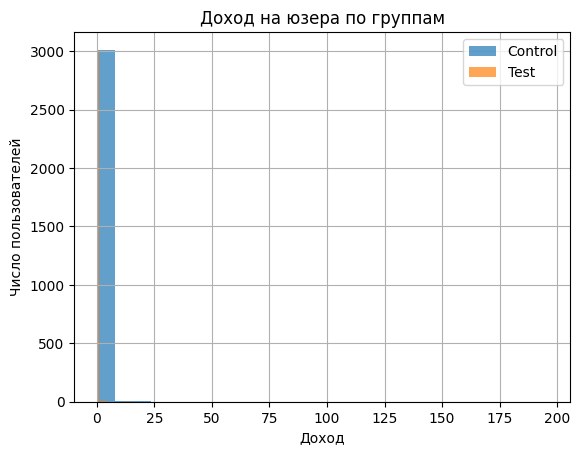

In [57]:
control.REVENUE.hist(bins = 25, alpha =0.7, label='Control')
test.REVENUE.hist(bins = 25, alpha =0.7, label='Test')
plt.title('Доход на юзера по группам')
plt.xlabel('Доход')
plt.ylabel('Число пользователей')
plt.legend();

Из данного графика также видим, что распределение не является нормальным.

Посмотрим, есть ли статистически значиммые различия между группами, используя критерий Манна-Уитни:

- распределение не является нормальным
- исследуем 2 независимые группы данных

In [58]:
mw_stats = stats.mannwhitneyu(x=df[(df['VARIANT_NAME'] == 'control')]['REVENUE'].values,
                                                  y=df[(df['VARIANT_NAME'] == 'variant')]['REVENUE'].values)
mw_stats

MannwhitneyuResult(statistic=12521564.0, pvalue=0.47825247965294926)

В результате расчета критерия Манна-Уитни получили высокое pvalue = 0.47 > alpha = 0.05

Т.е. наши группы не имеют статистически значимых различий.

In [59]:
mw_stats_new = stats.mannwhitneyu(x=df_new[(df_new['VARIANT_NAME'] == 'control')]['REVENUE'].values,
                                                  y=df_new[(df_new['VARIANT_NAME'] == 'variant')]['REVENUE'].values)
mw_stats_new

MannwhitneyuResult(statistic=4622832.0, pvalue=0.2444173738649208)

На очищенных данных также высокое pvalue = 0.24 > alpha = 0.05

Т.е. наши группы не имеют статистически значимых различий.

Таким образом, вносить изменения не рекомендуется, т.к.

- были допущены ошибки при А/Б-тесте, в результате которых мы потеряли почти половину данных.
- нет статистически значимых различий между группами в результате анализа имеющихся данных.

А/Б-тестирование рекомендуется переделать, учитывая допущенные ошибки.